In [388]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Lambda
from keras.optimizers import Adam
import keras.backend as K
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from padasip.filters import FilterRLS
from sklearn.ensemble import RandomForestRegressor
np.set_printoptions(precision=4, suppress=True)

X_train = pd.read_csv('X_train_change_base.csv', parse_dates=True, index_col='date')
y_train_change = pd.read_csv('y_train_change_base.csv', parse_dates=True, index_col='date')
y_train = pd.read_csv('y_train_original_base.csv', parse_dates=True, index_col='date')

X_test = pd.read_csv('X_val_change_base.csv', parse_dates=True, index_col='date')
y_test_change = pd.read_csv('y_val_change_base.csv', parse_dates=True, index_col='date')
y_test = pd.read_csv('y_val_original_base.csv', parse_dates=True, index_col='date')

X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train_lstm.shape, X_test_lstm.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_train_change.shape, y_test_change.shape

((150, 1, 177),
 (30, 1, 177),
 (150, 177),
 (150, 24),
 (30, 177),
 (30, 24),
 (150, 24),
 (30, 24))

In [305]:
prev_day_load_train = X_train.iloc[:, :24].values
prev_day_load_test = X_test.iloc[:, :24].values

prev_day_load_train.shape, prev_day_load_test.shape

((150, 24), (30, 24))

In [314]:
base_lightgbm_model = MultiOutputRegressor(LGBMRegressor(verbose=-1))
change_lightgbm_model = MultiOutputRegressor(LGBMRegressor(verbose=-1))

base_lightgbm_model.fit(X_train, y_train)
change_lightgbm_model.fit(X_train, y_train_change)

y_pred = base_lightgbm_model.predict(X_test)
y_pred_change = change_lightgbm_model.predict(X_test)
y_pred_change_transformed = y_pred_change + prev_day_load_test


# y_true = pd.DataFrame(y_test.values.flatten(), columns=['true'])

# y_pred = pd.DataFrame(y_pred.flatten(), columns=['pred'])

y_pred_df, y_pred_change_transformed_df, y_test_df = pd.Series(y_pred.flatten()), pd.Series(y_pred_change_transformed.flatten()), pd.Series(y_test.values.flatten())

results = pd.concat([y_pred_df, y_pred_change_transformed_df, y_test_df], axis=1)
results.columns = ['pred_base', 'pred_change', 'true']
px.line(results)

In [342]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)

X_mean_lstm = X_train_lstm.mean(axis=0)
X_std_lstm = X_train_lstm.std(axis=0)
X_min_lstm = X_train_lstm.min(axis=0)
X_max_lstm = X_train_lstm.max(axis=0)

y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_min = y_train.min(axis=0)
y_max = y_train.max(axis=0)

y_mean_change = y_train_change.mean(axis=0)
y_std_change = y_train_change.std(axis=0)
y_min_change = y_train_change.min(axis=0)
y_max_change = y_train_change.max(axis=0)

X_mean_lstm.shape, X_std_lstm.shape, X_mean.shape, X_std.shape, X_min.shape, X_max.shape, y_mean.shape, y_std.shape, y_min.shape, y_max.shape, y_mean_change.shape, y_std_change.shape, y_min_change.shape, y_max_change.shape

((1, 177),
 (1, 177),
 (177,),
 (177,),
 (177,),
 (177,),
 (24,),
 (24,),
 (24,),
 (24,),
 (24,),
 (24,),
 (24,),
 (24,))

Epoch 1/50
5/5 [==============================] - 1s 93ms/step - loss: 2361204.2500 - mae: 1012.9485 - val_loss: 2205667.5000 - val_mae: 1010.0616 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1871340.1250 - mae: 909.7819 - val_loss: 1909638.5000 - val_mae: 933.1154 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 1754641.2500 - mae: 873.0055 - val_loss: 1750812.0000 - val_mae: 891.5606 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 1586089.0000 - mae: 834.5612 - val_loss: 1694373.7500 - val_mae: 874.3355 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 1469258.6250 - mae: 803.0168 - val_loss: 1689698.8750 - val_mae: 873.2989 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 1342806.1250 - mae: 764.1295 - val_loss: 1661124.2500 - val_mae: 870.6007 - lr: 0.0010
Epoch 7/50
5/5 [==============================] - 0s 

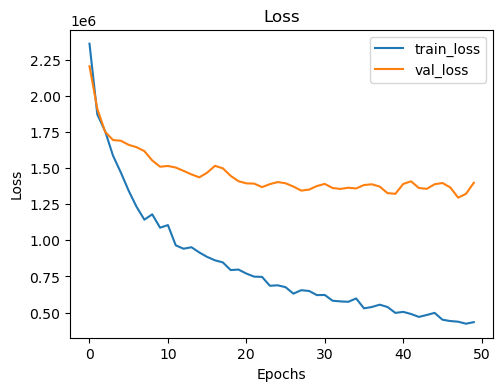

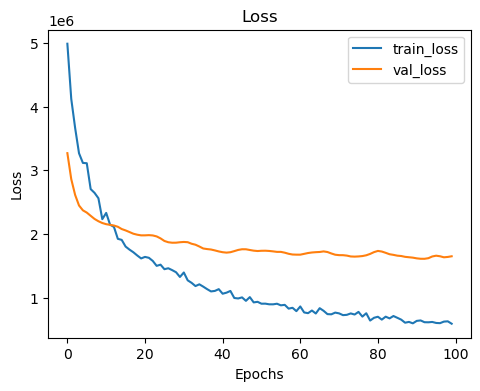

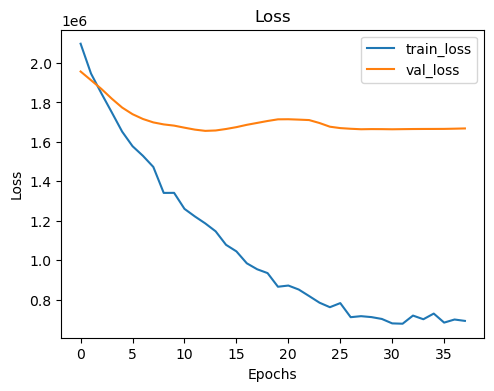

1/1 [==============================] - 1s 626ms/step


In [445]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def build_ann_model(X_train, y_train, X_test, y_test, X_mean, X_std, y_mean, y_std):
    # Convert mean and std to tensors (if needed)
    X_mean_tensor = K.constant(X_mean)
    X_std_tensor = K.constant(X_std)
    y_mean_tensor = K.constant(y_mean)
    y_std_tensor = K.constant(y_std)
    
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1:])))
    ann_model.add(Lambda(lambda x: (x - X_mean_tensor) / (X_std_tensor + 1e-8), name="input_normalization"))
    # ann_model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.3))
    # ann_model.add(Dropout(0.2))
    ann_model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    ann_model.add(Dropout(0.5))
    # ann_model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    ann_model.add(Dense(y_train.shape[1], activation='linear'))
    ann_model.add(Lambda(lambda x: (x * y_std_tensor) + y_mean_tensor, name="output_denormalization"))


    ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return ann_model

def build_lstm_model(X_train, y_train, X_test, y_test, X_mean, X_std, y_mean, y_std):
    # Convert mean and std to tensors (if needed)
    X_mean_tensor = K.constant(X_mean)
    X_std_tensor = K.constant(X_std)
    y_mean_tensor = K.constant(y_mean)
    y_std_tensor = K.constant(y_std)
    
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1:])))
    ann_model.add(Lambda(lambda x: (x - X_mean_tensor) / (X_std_tensor + 1e-8), name="input_normalization"))
    ann_model.add(LSTM(128, return_sequences=False))
    # ann_model.add(Dropout(0.2))
    # ann_model.add(LSTM(64, return_sequences=False))
    # ann_model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    ann_model.add(Dropout(0.5))
    # ann_model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    ann_model.add(Dense(y_train.shape[1], activation='linear'))
    ann_model.add(Lambda(lambda x: (x * y_std_tensor) + y_mean_tensor, name="output_denormalization"))


    ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return ann_model

ann_model_base = build_ann_model(X_train, y_train, X_test, y_test, X_mean, X_std, y_mean, y_std)
ann_model_change = build_ann_model(X_train, y_train_change, X_test, y_test_change, X_mean, X_std, y_mean_change, y_std_change)
lstm_model_change = build_lstm_model(X_train_lstm, y_train_change, X_test_lstm, y_test_change, X_mean_lstm, X_std_lstm, y_mean_change, y_std_change)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6, verbose=1),
]

history_base = ann_model_base.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks)
history_change = ann_model_change.fit(X_train, y_train_change, epochs=100, batch_size=64, verbose=1, validation_data=(X_test, y_test_change), callbacks=callbacks)
history_change_lstm = lstm_model_change.fit(X_train_lstm, y_train_change, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_lstm, y_test_change), callbacks=callbacks)

plot_history(history_base)
plot_history(history_change)
plot_history(history_change_lstm)

y_pred_base = ann_model_base.predict(X_test)
y_pred_change = ann_model_change.predict(X_test)
y_pred_change_lstm = lstm_model_change.predict(X_test_lstm)

y_pred_change_transformed = y_pred_change + prev_day_load_test
y_pred_change_lstm_transformed = y_pred_change_lstm + prev_day_load_test

y_pred_base_df, y_pred_change_transformed_df, y_pred_change_lstm_transformed_df, y_test_df = pd.Series(y_pred_base.flatten()), pd.Series(y_pred_change_transformed.flatten()), pd.Series(y_pred_change_lstm_transformed.flatten()), pd.Series(y_test.values.flatten())

results = pd.concat([y_test_df, y_pred_df, y_pred_change_transformed_df, y_pred_change_lstm_transformed_df], axis=1)
results.columns = ['true', 'pred_base', 'pred_change', 'pred_change_lstm']
px.line(results)

In [446]:
from sklearn.preprocessing import StandardScaler

# scalers = [StandardScaler() for _ in range(24)]

# def get_inputs_for_hour(hour, array):
#     # Assuming X_train is a DataFrame with a datetime index
#     # Filter the data for the specific hour
    
#     return array[:, hour]


# preds_1 = y_pred_base_df.values
# preds_2 = y_pred_change_lstm_transformed_df.values
# actuals = y_test_df.values


# def reshape_for_rls(preds_1, preds_2, actuals):
#     preds_1 = preds_1.reshape(-1, 24)
#     preds_2 = preds_2.reshape(-1, 24)
#     actuals = actuals.reshape(-1, 24)
    
#     return preds_1, preds_2, actuals

# preds_1, preds_2, actuals = reshape_for_rls(preds_1, preds_2, actuals)
# preds_1_scaled, preds_2_scaled, actuals_scaled = preds_1.copy(), preds_2.copy(), actuals.copy()

# for hour in range(24):
#     preds_hour_sample = get_inputs_for_hour(hour)  # shape (n_samples, n_models)
#     X_hour = scalers[hour].fit_transform(X_hour)
#     # pass this X_hour to RLS[hour]


In [447]:
from sklearn.preprocessing import StandardScaler

# Step 1: Fit on actual targets (e.g., training data)
scaler = StandardScaler()
scaler.fit(results['true'].values.reshape(-1, 1))

# Step 2: Transform both predictions and targets using the SAME scaler
y_true_scaled = scaler.transform(results['true'].values.reshape(-1, 1)).ravel().reshape(-1, 24)
y_pred1_scaled = scaler.transform(results['pred_base'].values.reshape(-1, 1)).ravel().reshape(-1, 24)
y_pred2_scaled = scaler.transform(results['pred_change_lstm'].values.reshape(-1, 1)).ravel().reshape(-1, 24)

y_true_scaled.shape, y_pred1_scaled.shape, y_pred2_scaled.shape

((30, 24), (30, 24), (30, 24))

In [451]:
rls_filters = [FilterRLS(n=2, mu=0.995) for _ in range(24)]
y_pred_rls = []

for i in range(0, y_true_scaled.shape[0]):
    for j in range(24):
        # print(i, j)
        
        y_pred_sample = rls_filters[j].predict([y_pred1_scaled[i, j], y_pred2_scaled[i, j]])
        rls_filters[j].adapt(y_true_scaled[i, j], np.array([y_pred1_scaled[i, j], y_pred2_scaled[i, j]]))    
        y_pred_rls.append(y_pred_sample)
            
        # i += 1
        # j += 1
        # print(i + j)
        # continue
        

y_pred_rls_np = np.array(y_pred_rls).reshape(-1, 1)
y_pred_rls_np = scaler.inverse_transform(y_pred_rls_np)
y_pred_rls_df = pd.DataFrame(y_pred_rls_np)

results['y_pred_rls'] = y_pred_rls_df

results[['true', 'pred_base', 'pred_change_lstm', 'y_pred_rls']]

,true,pred_base,pred_change_lstm,y_pred_rls
0,6985.563333,6944.827300,6843.194781,5340.773024
1,6708.094286,6636.220999,6558.286808,4881.219351
2,6317.820000,6267.133015,6363.375629,61.128093
3,6085.862000,6045.251503,6062.263695,3299.258930
4,5897.067143,5861.592701,5829.894900,4218.206812
...,...,...,...,...
715,7002.485000,7502.499715,7532.548558,7537.670302
716,8319.034167,7888.422862,7900.075751,7938.598808
717,8191.248182,7865.644819,8027.167474,7992.268982
718,7481.504444,7642.580082,7794.184043,7732.868376


In [452]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42)

# X_train_rf = results[['pred_base', 'pred_change_lstm']].values
# y_train_rf = results['true'].values
# X_test_rf = results[['pred_base', 'pred_change_lstm']].values
# y_test_rf = results['true'].values

# rf.fit(X_train_rf, y_train_rf)
# y_pred_rf = rf.predict(X_test_rf)
# results['y_pred_rf'] = y_pred_rf

# px.line(results[['true', 'pred_base', 'pred_change_lstm', 'y_pred_rf']])

px.line(results)

In [371]:
results

,true,pred_base,pred_change,pred_change_lstm
0,6985.563333,6944.827300,7068.075333,6912.319094
1,6708.094286,6636.220999,6485.026967,6549.000782
2,6317.820000,6267.133015,6415.266300,6372.149139
3,6085.862000,6045.251503,6047.998568,5925.913410
4,5897.067143,5861.592701,5935.509135,5798.351046
...,...,...,...,...
715,7002.485000,7502.499715,7725.061826,7519.311101
716,8319.034167,7888.422862,7806.531264,7974.663534
717,8191.248182,7865.644819,7980.908342,8174.750299
718,7481.504444,7642.580082,7427.408557,7723.803500


In [360]:
base_lightgbm_model = MultiOutputRegressor(LGBMRegressor(verbose=-1))
change_lightgbm_model = MultiOutputRegressor(LGBMRegressor(verbose=-1))

base_lightgbm_model.fit(X_train, y_train)
change_lightgbm_model.fit(X_train, y_train_change)

y_pred = base_lightgbm_model.predict(X_test)
y_pred_change = change_lightgbm_model.predict(X_test)
y_pred_change_transformed = y_pred_change + prev_day_load_test


# y_true = pd.DataFrame(y_test.values.flatten(), columns=['true'])

# y_pred = pd.DataFrame(y_pred.flatten(), columns=['pred'])

y_pred_df, y_pred_change_transformed_df, y_test_df = pd.Series(y_pred.flatten()), pd.Series(y_pred_change_transformed.flatten()), pd.Series(y_test.values.flatten())

results = pd.concat([y_pred_df, y_pred_change_transformed_df, y_test_df], axis=1)
results.columns = ['pred_base', 'pred_change', 'true']
px.line(results)

Epoch 1/50
5/5 [==============================] - 3s 126ms/step - loss: 0.0885 - mae: 0.2411 - val_loss: 0.0567 - val_mae: 0.1810 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0394 - mae: 0.1451 - val_loss: 0.0456 - val_mae: 0.1674 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0265 - mae: 0.1158 - val_loss: 0.0252 - val_mae: 0.1150 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0217 - mae: 0.0994 - val_loss: 0.0247 - val_mae: 0.1154 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0201 - mae: 0.0977 - val_loss: 0.0232 - val_mae: 0.1078 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0187 - mae: 0.0905 - val_loss: 0.0202 - val_mae: 0.1029 - lr: 0.0010
Epoch 7/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0175 - mae: 0.0873 - val_loss: 0.0202 - val_mae: 0.1030 - lr: 0.0010
Epoch

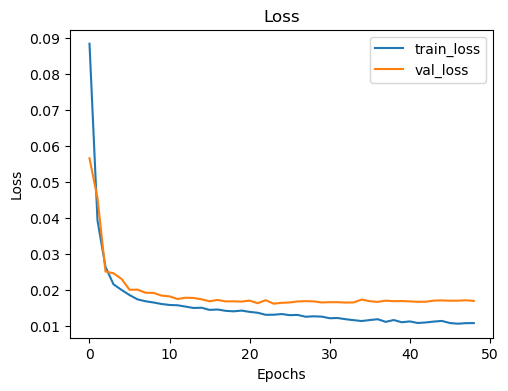

1/1 [==============================] - 0s 252ms/step


(30, 24)

In [ ]:

    
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

X_train_LSTM = X_train_scaled.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_LSTM = X_test_scaled.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add(Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.3))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='linear'))

# model.fit(X_train, y_train)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6, verbose=1),
]

history = model.fit(X_train_LSTM, y_train_scaled, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_LSTM, y_test_scaled), callbacks=callbacks)
plot_history(history)

y_pred = model.predict(X_test_LSTM)

y_true = pd.DataFrame(y_test_scaled.flatten(), columns=['true'])
y_pred_df = pd.DataFrame(y_pred.flatten(), columns=['pred'])

y_pred.shape

In [277]:
results = pd.concat([y_true, y_pred_df], axis=1)
px.line(results)

In [278]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = root_mean_squared_error(y_true, y_pred_df)
mae = mean_absolute_error(y_true, y_pred_df)
mape = mean_absolute_percentage_error(y_true, y_pred_df)

print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}')

RMSE: 0.12766695985057275, MAE: 0.08711243867096849, MAPE: 1.1027544824109012


In [279]:
y_true_base = y_scaler.inverse_transform(y_test_scaled)
y_pred_base = y_scaler.inverse_transform(y_pred)

y_true_base = pd.DataFrame(y_true_base.flatten(), columns=['true'])
y_pred_base_flat_df = pd.DataFrame(y_pred_base.flatten(), columns=['pred'])
y_pred_base_df = pd.DataFrame(y_pred_base, columns=y_train.columns, index=y_test.index)

results_base = pd.concat([y_true_base, y_pred_base_flat_df], axis=1)
px.line(results_base)

In [253]:
X_test

,Prev_Day_Net_Load_Demand_Hour_0,Prev_Day_Net_Load_Demand_Hour_1,Prev_Day_Net_Load_Demand_Hour_2,Prev_Day_Net_Load_Demand_Hour_3,Prev_Day_Net_Load_Demand_Hour_4,Prev_Day_Net_Load_Demand_Hour_5,Prev_Day_Net_Load_Demand_Hour_6,Prev_Day_Net_Load_Demand_Hour_7,Prev_Day_Net_Load_Demand_Hour_8,Prev_Day_Net_Load_Demand_Hour_9,...,Cloud_Cover_Forecast_Hour_23,Is_Holiday,Is_Weekend,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
date,,,,,,,,,,,,,,,,,,,,,
2024-06-01,7085.397143,6695.761250,6342.965000,6033.391667,5794.117778,5779.021111,5904.939000,5106.672727,3579.885000,1323.686667,...,100.0,0,1,0,0,0,0,0,1,0
2024-06-02,6985.563333,6708.094286,6317.820000,6085.862000,5897.067143,5778.275714,5769.544286,5231.090000,2853.610917,1356.853583,...,100.0,0,1,0,0,0,0,0,0,1
2024-06-03,6708.504000,6390.627000,6025.201250,5879.952000,5698.308889,5649.703000,5720.877500,5436.780000,4305.905000,708.665750,...,100.0,0,0,1,0,0,0,0,0,0
2024-06-04,6479.553750,6216.448750,5976.314286,5804.510000,5684.110000,5648.096000,5857.617143,5142.353333,3991.681667,3065.681583,...,100.0,0,0,0,1,0,0,0,0,0
2024-06-05,6656.283333,6250.858889,5875.511667,5707.336667,5563.736667,5568.432857,5818.408571,5338.750833,5386.653333,3311.803917,...,58.0,0,0,0,0,1,0,0,0,0
2024-06-06,6348.605000,5981.970000,5646.801250,5509.838889,5319.903750,5349.647500,5712.910000,5146.985455,2813.780909,734.295692,...,37.0,0,0,0,0,0,1,0,0,0
2024-06-07,6604.094444,6170.223333,5796.112000,5668.404286,5563.304000,5478.680000,5799.198889,5283.050833,3147.152500,382.495800,...,33.0,0,0,0,0,0,0,1,0,0
2024-06-08,6753.120909,6400.056250,6043.649091,5838.347500,5617.007143,5605.770000,5760.680000,5253.410833,4500.431538,1984.335400,...,33.0,0,1,0,0,0,0,0,1,0
2024-06-09,6778.604444,6481.387500,6087.385000,5796.201667,5645.323333,5617.881429,5537.453333,4305.676667,1961.491083,-475.175167,...,39.0,0,1,0,0,0,0,0,0,1


In [254]:
prev_load_columns = X_test.iloc[:, 0:24]
prev_load_columns

,Prev_Day_Net_Load_Demand_Hour_0,Prev_Day_Net_Load_Demand_Hour_1,Prev_Day_Net_Load_Demand_Hour_2,Prev_Day_Net_Load_Demand_Hour_3,Prev_Day_Net_Load_Demand_Hour_4,Prev_Day_Net_Load_Demand_Hour_5,Prev_Day_Net_Load_Demand_Hour_6,Prev_Day_Net_Load_Demand_Hour_7,Prev_Day_Net_Load_Demand_Hour_8,Prev_Day_Net_Load_Demand_Hour_9,...,Prev_Day_Net_Load_Demand_Hour_14,Prev_Day_Net_Load_Demand_Hour_15,Prev_Day_Net_Load_Demand_Hour_16,Prev_Day_Net_Load_Demand_Hour_17,Prev_Day_Net_Load_Demand_Hour_18,Prev_Day_Net_Load_Demand_Hour_19,Prev_Day_Net_Load_Demand_Hour_20,Prev_Day_Net_Load_Demand_Hour_21,Prev_Day_Net_Load_Demand_Hour_22,Prev_Day_Net_Load_Demand_Hour_23
date,,,,,,,,,,,,,,,,,,,,,
2024-06-01,7085.397143,6695.761250,6342.965000,6033.391667,5794.117778,5779.021111,5904.939000,5106.672727,3579.885000,1323.686667,...,319.543833,2352.293000,4641.520000,4250.974167,5920.602500,7552.282222,7998.100000,7930.547778,7555.180000,7277.484000
2024-06-02,6985.563333,6708.094286,6317.820000,6085.862000,5897.067143,5778.275714,5769.544286,5231.090000,2853.610917,1356.853583,...,842.110083,3851.070000,2312.410833,5298.697500,6036.901111,7181.049000,7758.053000,7824.534444,7546.061111,7245.993750
2024-06-03,6708.504000,6390.627000,6025.201250,5879.952000,5698.308889,5649.703000,5720.877500,5436.780000,4305.905000,708.665750,...,-192.300583,1310.144667,2863.995833,2920.432500,5939.192727,7332.245833,7783.859000,7739.388750,7443.573636,7077.758333
2024-06-04,6479.553750,6216.448750,5976.314286,5804.510000,5684.110000,5648.096000,5857.617143,5142.353333,3991.681667,3065.681583,...,820.205667,4766.231667,1760.770825,5952.319167,6504.442500,7461.102000,7984.991000,7861.341250,7468.874444,7121.425000
2024-06-05,6656.283333,6250.858889,5875.511667,5707.336667,5563.736667,5568.432857,5818.408571,5338.750833,5386.653333,3311.803917,...,7302.233333,7719.263333,7586.445000,6449.340909,6749.740000,7400.830833,7601.219091,7559.526667,7182.170000,6681.612857
2024-06-06,6348.605000,5981.970000,5646.801250,5509.838889,5319.903750,5349.647500,5712.910000,5146.985455,2813.780909,734.295692,...,-1710.903750,-1193.058167,884.837217,3259.005833,5737.261667,7374.227000,7802.375455,7828.527500,7415.120000,6998.763750
2024-06-07,6604.094444,6170.223333,5796.112000,5668.404286,5563.304000,5478.680000,5799.198889,5283.050833,3147.152500,382.495800,...,1843.437225,2101.392883,2132.571833,4356.540000,6193.661667,7497.320909,7965.329167,7816.912222,7627.041000,7230.411000
2024-06-08,6753.120909,6400.056250,6043.649091,5838.347500,5617.007143,5605.770000,5760.680000,5253.410833,4500.431538,1984.335400,...,-1009.690833,212.154917,612.403585,3311.974167,5594.175833,7508.971250,7940.273000,7849.704286,7484.351000,7119.547778
2024-06-09,6778.604444,6481.387500,6087.385000,5796.201667,5645.323333,5617.881429,5537.453333,4305.676667,1961.491083,-475.175167,...,-3186.097000,-1432.267892,1062.600717,3144.136667,5570.149091,7445.331000,8116.251250,7937.146667,7682.252500,7203.110000


In [281]:
y_pred_base_df

,Net_Load_Demand_Hour_0,Net_Load_Demand_Hour_1,Net_Load_Demand_Hour_2,Net_Load_Demand_Hour_3,Net_Load_Demand_Hour_4,Net_Load_Demand_Hour_5,Net_Load_Demand_Hour_6,Net_Load_Demand_Hour_7,Net_Load_Demand_Hour_8,Net_Load_Demand_Hour_9,...,Net_Load_Demand_Hour_14,Net_Load_Demand_Hour_15,Net_Load_Demand_Hour_16,Net_Load_Demand_Hour_17,Net_Load_Demand_Hour_18,Net_Load_Demand_Hour_19,Net_Load_Demand_Hour_20,Net_Load_Demand_Hour_21,Net_Load_Demand_Hour_22,Net_Load_Demand_Hour_23
date,,,,,,,,,,,,,,,,,,,,,
2024-06-01,6723.392090,6181.660645,6157.969727,5848.209961,5629.082031,5558.734375,5675.974609,4809.702148,3394.718262,1478.013794,...,643.785522,1533.696533,3017.229736,4563.877441,6606.629883,7517.687500,7930.033203,7889.255859,7665.542969,6967.682617
2024-06-02,6311.381348,6129.340332,6016.257324,5615.447266,5565.164551,5502.330566,5757.349609,5522.747070,3983.001465,2515.960693,...,1050.207397,2037.796387,3170.321289,4445.123047,6421.721191,7168.595703,7667.909180,7713.443359,7394.957520,6825.661621
2024-06-03,6674.842773,5965.548340,5983.884277,5718.036621,5555.805664,5458.856934,5502.396484,4818.146484,3504.254883,1249.740356,...,133.150436,1055.614136,2991.209961,4601.164551,6512.024902,7596.639160,8021.927734,7755.837402,7560.934082,6795.708496
2024-06-04,6566.874512,6167.604980,5774.905273,5634.696777,5527.041016,5484.223633,6042.549805,6189.127930,4947.684082,3082.134033,...,1293.355957,2725.966309,3884.734863,5377.144043,6872.264648,7539.239258,7787.270508,7712.094727,7238.444824,6983.448730
2024-06-05,6772.332031,5992.133789,5989.494141,5568.520508,5572.741699,5538.297852,5708.235352,5037.427246,3489.892334,1559.058960,...,-951.638367,-141.233658,2083.743164,4200.084961,5767.956055,7784.064453,8003.610840,7789.749023,7599.388184,6888.757812
2024-06-06,6630.548828,6221.092285,6018.877930,5806.878906,5759.737305,5614.478516,5796.857422,4941.677734,3447.001221,1115.009888,...,-311.438538,527.660522,2309.140137,4551.716309,6153.453613,7806.082031,7967.275879,7824.457031,7804.931152,7005.739258
2024-06-07,6516.780273,6072.719727,6007.808594,5715.248047,5746.180176,5667.393066,5752.321289,5005.120117,3375.967773,1393.400513,...,-778.739929,100.309021,1916.684448,4161.313477,5756.766113,7687.534180,7955.104492,7808.720215,7788.839355,7031.286621
2024-06-08,6639.426758,6192.073242,6128.622070,5860.774902,5783.226074,5574.766602,5763.374512,4639.290527,3231.239990,1095.756226,...,-170.263214,708.753784,2467.111572,4390.114746,6275.221191,7628.616211,7926.887695,7797.799805,7867.809082,7085.377441
2024-06-09,6572.237305,6176.740234,6183.424805,5797.221191,5754.309082,5610.872559,5828.206543,4688.512695,3196.840576,904.838684,...,-208.769394,563.240784,2256.001221,4090.403564,5998.280273,7595.384277,7915.663086,7872.136230,7762.466797,6986.607422


In [282]:
y_test

,Net_Load_Demand_Hour_0,Net_Load_Demand_Hour_1,Net_Load_Demand_Hour_2,Net_Load_Demand_Hour_3,Net_Load_Demand_Hour_4,Net_Load_Demand_Hour_5,Net_Load_Demand_Hour_6,Net_Load_Demand_Hour_7,Net_Load_Demand_Hour_8,Net_Load_Demand_Hour_9,...,Net_Load_Demand_Hour_14,Net_Load_Demand_Hour_15,Net_Load_Demand_Hour_16,Net_Load_Demand_Hour_17,Net_Load_Demand_Hour_18,Net_Load_Demand_Hour_19,Net_Load_Demand_Hour_20,Net_Load_Demand_Hour_21,Net_Load_Demand_Hour_22,Net_Load_Demand_Hour_23
date,,,,,,,,,,,,,,,,,,,,,
2024-06-01,6985.563333,6708.094286,6317.820000,6085.862000,5897.067143,5778.275714,5769.544286,5231.090000,2853.610917,1356.853583,...,842.110083,3851.070000,2312.410833,5298.697500,6036.901111,7181.049000,7758.053000,7824.534444,7546.061111,7245.993750
2024-06-02,6708.504000,6390.627000,6025.201250,5879.952000,5698.308889,5649.703000,5720.877500,5436.780000,4305.905000,708.665750,...,-192.300583,1310.144667,2863.995833,2920.432500,5939.192727,7332.245833,7783.859000,7739.388750,7443.573636,7077.758333
2024-06-03,6479.553750,6216.448750,5976.314286,5804.510000,5684.110000,5648.096000,5857.617143,5142.353333,3991.681667,3065.681583,...,820.205667,4766.231667,1760.770825,5952.319167,6504.442500,7461.102000,7984.991000,7861.341250,7468.874444,7121.425000
2024-06-04,6656.283333,6250.858889,5875.511667,5707.336667,5563.736667,5568.432857,5818.408571,5338.750833,5386.653333,3311.803917,...,7302.233333,7719.263333,7586.445000,6449.340909,6749.740000,7400.830833,7601.219091,7559.526667,7182.170000,6681.612857
2024-06-05,6348.605000,5981.970000,5646.801250,5509.838889,5319.903750,5349.647500,5712.910000,5146.985455,2813.780909,734.295692,...,-1710.903750,-1193.058167,884.837217,3259.005833,5737.261667,7374.227000,7802.375455,7828.527500,7415.120000,6998.763750
2024-06-06,6604.094444,6170.223333,5796.112000,5668.404286,5563.304000,5478.680000,5799.198889,5283.050833,3147.152500,382.495800,...,1843.437225,2101.392883,2132.571833,4356.540000,6193.661667,7497.320909,7965.329167,7816.912222,7627.041000,7230.411000
2024-06-07,6753.120909,6400.056250,6043.649091,5838.347500,5617.007143,5605.770000,5760.680000,5253.410833,4500.431538,1984.335400,...,-1009.690833,212.154917,612.403585,3311.974167,5594.175833,7508.971250,7940.273000,7849.704286,7484.351000,7119.547778
2024-06-08,6778.604444,6481.387500,6087.385000,5796.201667,5645.323333,5617.881429,5537.453333,4305.676667,1961.491083,-475.175167,...,-3186.097000,-1432.267892,1062.600717,3144.136667,5570.149091,7445.331000,8116.251250,7937.146667,7682.252500,7203.110000
2024-06-09,6768.571667,6455.144000,6111.224000,5870.165000,5761.254286,5677.653750,5717.176667,4550.473636,3063.975833,2173.845917,...,-3085.623750,465.731667,1014.868417,3716.457500,5727.520769,7298.375000,8028.583000,8040.352222,7660.703750,7222.312500


In [285]:
base_load_pred = prev_load_columns.values + y_pred_base_df.values
base_load_true = prev_load_columns.values + y_test.values
# base_load_pred = y_pred_base_df.values
# base_load_true = y_test.values

base_load_true = pd.DataFrame(base_load_true.flatten(), columns=['true'])
base_load_pred = pd.DataFrame(base_load_pred.flatten(), columns=['pred'])

px.line(pd.concat([base_load_true, base_load_pred], axis=1))

In [283]:
pd.DataFrame(base_load_pred)

,pred
0,13808.789233
1,12877.421895
2,12500.934727
3,11881.601628
4,11423.199809
...,...
715,15070.642934
716,15905.719512
717,15936.376779
718,15470.487933


In [220]:
y_train_original = pd.read_csv('y_train_original_base.csv', parse_dates=True, index_col='date')
px.line(y_train_original.values.flatten())